# Natural Language Processing Project: Twitter Sentiment Analysis

## Context

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

## Problem statement

Perform a sentiment analysis of the tweets from customers serviced by each major U.S. airline.


## Dataset description:

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The dataset has the following columns:
- tweet_id                                                           
- airline_sentiment                                               
- airline_sentiment_confidence                               
- negativereason                                                   
- negativereason_confidence                                    
- airline                                                                    
- airline_sentiment_gold                                              
- name     
- negativereason_gold 
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location 
- user_timezone

## Mount drive and install packages

In [1]:
# mount the Google drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# uncomment and install, if necessary

# !pip install vaderSentiment    # install vader sentiment package
# !pip install textblob          # install textblob package
# !pip install contractions      # install contractions

## Import the necessary libraries

In [3]:
#import libraries below
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt                                           
import seaborn as sns                                                    

from collections import Counter                                                 # counter for key-value pairs in an object

import re, string, unicodedata                                                  # import text preprocessing libraries
import contractions                                                             # import contractions library
from bs4 import BeautifulSoup                                                   # import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator                 # import wordcloud of a corpus, stopwords
import nltk                                                                     # import nltk library
from nltk.corpus import stopwords                                               # import nltk stopwords
from nltk.tokenize import word_tokenize, sent_tokenize                          # import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer                                 # import Lemmatizer
from nltk.stem.porter import PorterStemmer                                      # import Stemmer

from sklearn.feature_extraction.text import CountVectorizer                     # import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer                     # import TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier                             # import Random Forest Classifier
from sklearn.metrics import classification_report                               # import classification report
from sklearn.model_selection import cross_val_score 

# download stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

## Import the data

In [5]:
# load the dataset of tweets
path1 = "/content/drive/MyDrive/Colab Notebooks/Intro to NLP/Tweets.csv"
tweets = pd.read_csv(path1)
# create copy of dataset
df = tweets.copy()

## Oveview of the dataset

In [6]:
# print the shape of the dataset
df.shape

(14640, 15)

- The dataset of tweets contains 14,640 rows and 15 columns.

In [7]:
# show first five rows of data
df.head(n=5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
# show last five rows of data
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.35,NaN,0.00,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.00,Customer Service Issue,1.00,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.00,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.00,Customer Service Issue,0.67,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.68,NaN,0.00,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [9]:
# show summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- 7 of the 15 columns contain missing data
- However, fortunately, these columns will only be useful during exploratory data analysis, rather than for building our model(s)

## Data cleaning

In [10]:
# convert all columns with dtype object into category to save memory
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [11]:
# convert tweet_id into a category to save memory
df['tweet_id'] = df['tweet_id'].astype('category')

In [12]:
# convert tweet_created into a datetime to allow for time series analysis
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df['tweet_created'] = df['tweet_created'].astype('datetime64[ns]')

In [13]:
# show summary of dataset after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

- There a 12 columns of the dtype category, two columns of the dtype float64, and one column with the dtype int64

##Exploratory data analysis (EDA)

### Numerical variables

In [14]:
# show summary of all numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
airline_sentiment_confidence,14640.00,0.90,0.16,0.34,0.69,1.00,1.00,1.00
negativereason_confidence,10522.00,0.64,0.33,0.00,0.36,0.67,1.00,1.00
retweet_count,14640.00,0.08,0.75,0.00,0.00,0.00,0.00,44.00


- Of the 14,640 tweets, the tweet with maximum number of retweets was only 44. This signifies that none of these tweets were from highly influential individuals or pertained to an event with a significant amount of engagement (i.e., a "viral" moment).

### Categorical variables

In [15]:
# show summary of all categorical variables
df.describe(include=['category']).T

,count,unique,top,freq
tweet_id,14640,14485,570281470507352064,2
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_location,9907,3081,"Boston, MA",157


- During the period, the user with the maximum number of tweets, JetBlueNews, tweeted 32 times (~5 tweets/per day)

### Datetime variables

In [16]:
# show summary of datetime variable
df.describe(include=['datetime']).T

,count,unique,top,freq,first,last
tweet_created,14640,14247,2015-02-24 17:54:34,5,2015-02-17 07:36:05,2015-02-24 19:53:37


- The tweets were collected from February 17, 2015 to February 24, 2015

#### Number of tweets by day

In [17]:
# show number of tweets by day
by_date = df.groupby(pd.Grouper(key='tweet_created', axis=0, freq='D')).count()['tweet_id']
print(by_date)

tweet_created
2015-02-17     953
2015-02-18    1416
2015-02-19    1298
2015-02-20    1512
2015-02-21    1418
2015-02-22    2392
2015-02-23    3515
2015-02-24    2136
Freq: D, Name: tweet_id, dtype: int64


- February 23rd, a Monday, was the day with the most tweets
- February 17th, a Tuesday, was the day with the fewest tweets

## Data visualizations

In [18]:
# function to create labeled barplots

def labeled_barplot(data, feature, hue=None, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    hue: whether to groupby another dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
        
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette='viridis',
        order = data[feature].value_counts().index,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [19]:
# import the figure size for the visualizations
from matplotlib import rcParams

### Distribution of sentiment across all the tweets

In [20]:
# show number of tweets by sentiment
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

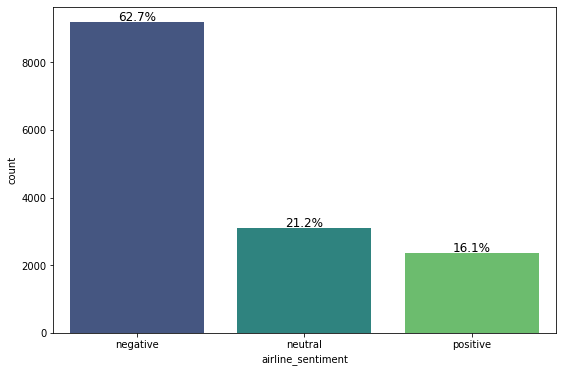

In [21]:
# create labled barplot for number of tweets by sentiment
rcParams['figure.figsize'] = 9,6
labeled_barplot(df,'airline_sentiment',perc=True)

- There are **~4 times** as many tweets with negative sentiment as positive sentiment
- There are ~3 times as many tweets with negative sentiment as neutral sentiment
- This indicates that our classification model(s) will be biased by this class imbalance

### Distribution of all tweets among each airline

In [22]:
# show number of tweets by airline
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

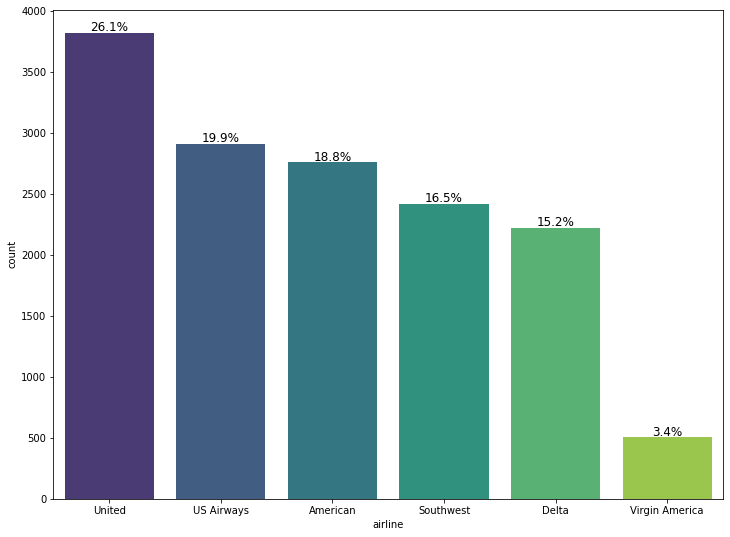

In [23]:
# create labeled barplot of number of tweets by airline
rcParams['figure.figsize'] = 12,9
labeled_barplot(df,'airline',perc=True)

- Tweets concerning United Airlines received the most tweets (~26.1% of all tweets)
- Tweets concerning Virigin America received the fewest tweets (~3.4% of all tweets)
- The number of tweets is likley dependent on the size of the carrier (i.e., number of flights per day)
- A potential key performance metric (KPM) of customer service could be the ratio of positive to negative tweets per enplaned passenger

### Distribution of sentiment of tweets for each airline 

In [24]:
# show number of tweets by sentiment per airline
df.groupby('airline')['airline_sentiment'].value_counts()

airline                 
American        negative    1960
                neutral      463
                positive     336
Delta           negative     955
                neutral      723
                positive     544
Southwest       negative    1186
                neutral      664
                positive     570
US Airways      negative    2263
                neutral      381
                positive     269
United          negative    2633
                neutral      697
                positive     492
Virgin America  negative     181
                neutral      171
                positive     152
Name: airline_sentiment, dtype: int64

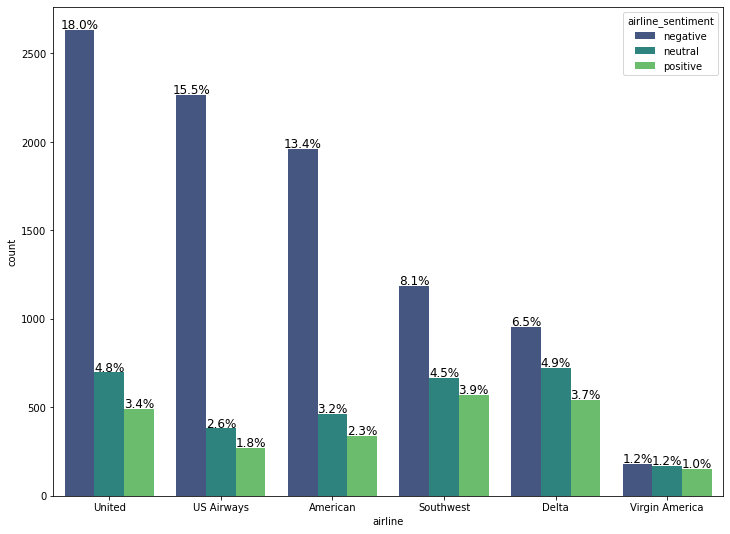

In [25]:
# create labeled barplot for number of tweets by sentiment per airline
labeled_barplot(df,'airline','airline_sentiment',perc=True)

- Using the proposed KPM explained above:
  - US Airways performed the worst, with **~9x** as many negative tweets as positive tweets
  - Virgin America performed the best, with only 1.2x as many negative tweets as positive tweets 

### Distribution of all the negative reasons

In [26]:
# show number of tweets by reason for negative sentiment
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

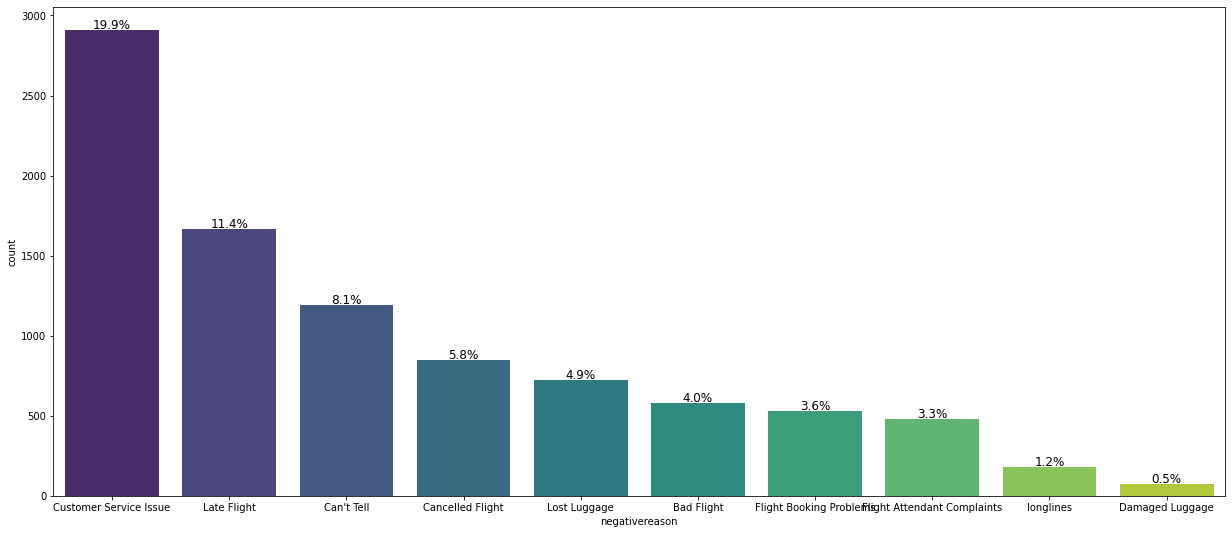

In [27]:
# create labeled barplot for number of tweets per reason for negative sentiment
rcParams['figure.figsize'] = 21,9
labeled_barplot(df,'negativereason',perc=True)

- The top five reasons given for a negative tweet are: 
  - Customer Service Issue
  - Late Flight
  - Can't Tell
  - Cancelled Flight
  - Lost Luggage

### Word cloud of tweets with positive sentiment

In [28]:
def wordcloud(tweets):
  words = ' '.join(tweets['text'])
  cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
  plt.figure(1,figsize=(12, 12))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

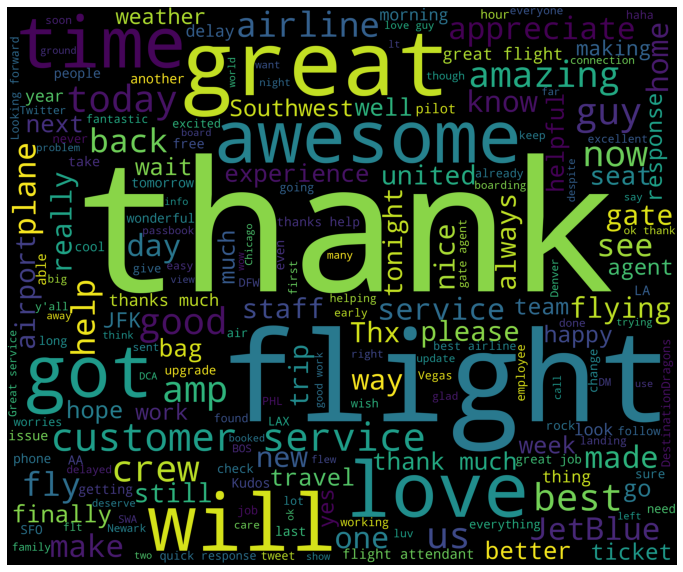

In [29]:
# create word cloud for positive tweets
pos_tweets = df[df['airline_sentiment']=='positive']
wordcloud(pos_tweets)

- As expected, words like thank, awesome, love, great, amazing were the most commonly used in positive tweets

### Word cloud of tweets with negative sentiment

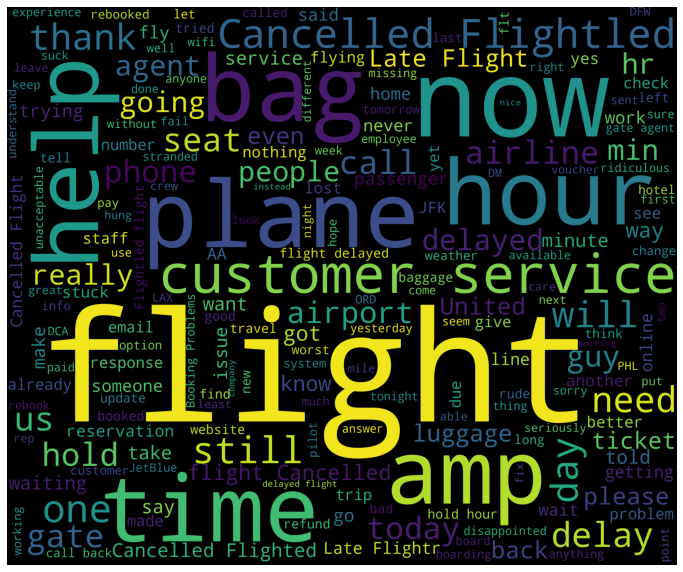

In [30]:
# create world cloud for negative tweets
neg_tweets = df[df['airline_sentiment']=='negative']
wordcloud(neg_tweets)

- Flight is a very common word in both positive and negative tweets, indicating that this word will likely not contribute to a classification model
- As expected from the negative reasons shown above, words like bag, time, now, cancelled, and plane were the most commonly used in negative tweets 

## Follow-on data cleaning

In [31]:
column_list = df.columns.to_list()

In [32]:
# identify columns used for model building
columns = ['text','airline_sentiment']

In [33]:
# identify columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [34]:
# drop all other columns except “text” and “airline_sentiment”
df_model = df.drop(columns = drop_columns)

In [35]:
# confirm new shape of the dataset
df_model.shape

(14640, 2)

In [36]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (non-turncated text column.)
#print head of new dataset
df_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


## Data pre-processing

### Clean text

In [37]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
df_model['text'] = df_model['text'].apply(lambda x: clean_text(x))
df_model.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


### Tokenization

In [38]:
df_model['text'] = df_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
df_model.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


### Normalize text

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_model['text'] = df_model.apply(lambda row: normalize(row['text']), axis=1)
df_model.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


## Supervised Learning

### Bag of Words (Count Vectorizer)

In [41]:
# set independent variable for classification model
targets = sorted(df_model.airline_sentiment.unique().to_list())
print(targets)

['negative', 'neutral', 'positive']


In [42]:
# set the max number of features at 1000
count_vec = CountVectorizer(max_features=1000)
# convert text to numbers with CountVectorizer
data_features_count = count_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_count = data_features_count.toarray()                        

In [43]:
# show shape of the feature vector
data_features_count.shape

(14640, 1000)

In [44]:
# split data into training and testing set
X_count = data_features_count
y = df_model.airline_sentiment
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, shuffle=False, random_state=42)

In [45]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_count, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

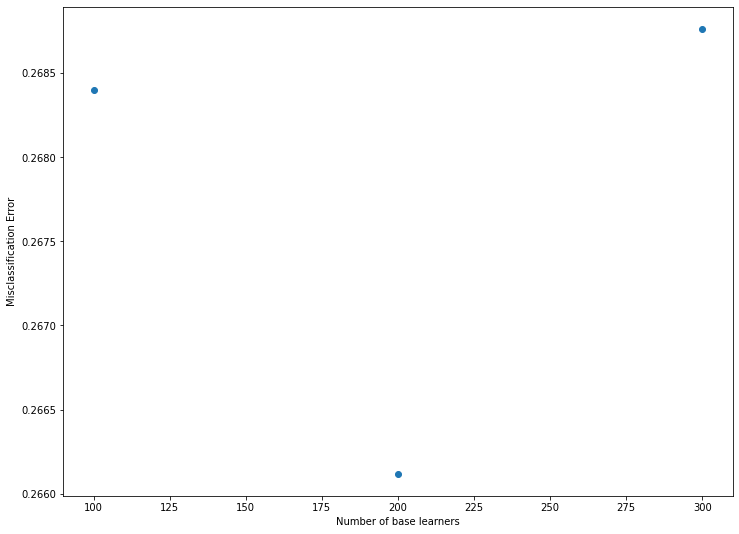

In [46]:
# set figure size
rcParams['figure.figsize'] = 9,6
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [47]:
# train the best model
clf_count = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf_count.fit(X_train_count, y_train)
clf_count.score(X_test_count, y_test)
count_predicted = clf_count.predict(X_test_count)

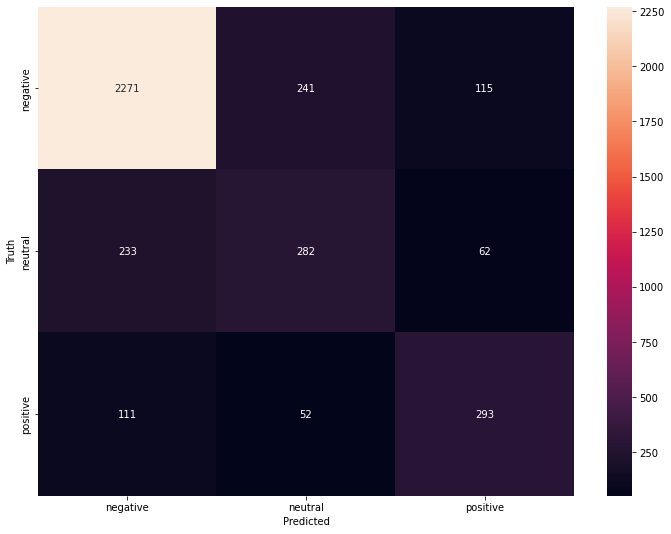

In [48]:
from sklearn.metrics import confusion_matrix
#create confusion matrix for Count Vectorizer
cm_count=confusion_matrix(y_test,count_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_count,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

- The model is classifying 2,271 out of 2,627 negative tweets correctly (86%), 282 out of 577 neutral tweets correctly (49%), and 293 out of 456 positive tweets correctly (64%)

In [49]:
all_features_count = count_vec.get_feature_names()                              # instantiate the features from the vectorizer
top_features_count=''                                                           # addition of top 40 features into top_feature after training the model
feat=clf_count.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features_count+=all_features_count[i]
    top_features_count+=', '
    
top_features_count

'thank, delay, great, love, hours, hold, awesome, cancel, bag, get, hour, amaze, best, would, fly, please, worst, wait, service, help, plane, time, customer, call, make, fleek, lose, go, never, need, late, miss, still, say, flight, try, luggage, fleet, good, one, '

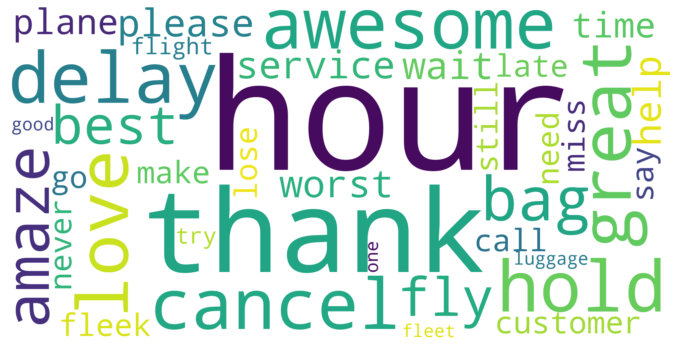

In [50]:
from wordcloud import WordCloud
# create word cloud
wordcloud_count = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features_count)

# show word cloud
plt.imshow(wordcloud_count, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [51]:
# saving variables for model
y_train_count = y_train
y_test_count = y_test

### Tf-Idf Vectorizer.

In [52]:
# set the max number of features at 1000
tfidf_vec = TfidfVectorizer(max_features=1000)
# convert test to numbers with TfidfVectorizer
data_features_idf = tfidf_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_idf = data_features_idf.toarray()                        

In [53]:
# show shape of the feature vector
data_features_idf.shape

(14640, 1000)

In [54]:
# split data into training and testing set
X_idf = data_features_idf
y = df_model.airline_sentiment
X_train_idf, X_test_idf, y_train, y_test = train_test_split(X_idf, y, test_size=0.25, shuffle=False, random_state=42)

In [55]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_idf, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

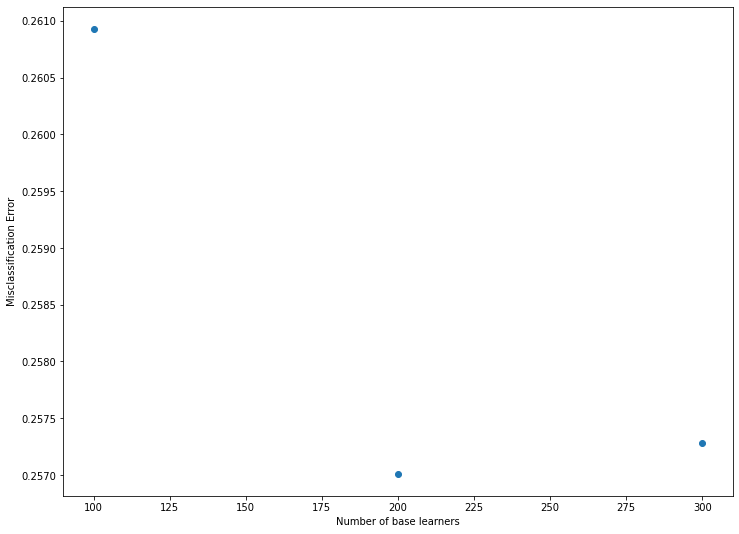

In [56]:
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [57]:
# train the best model
clf = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf.fit(X_train_idf, y_train)
clf.score(X_test_idf, y_test)
tf_idf_predicted = clf.predict(X_test_idf)

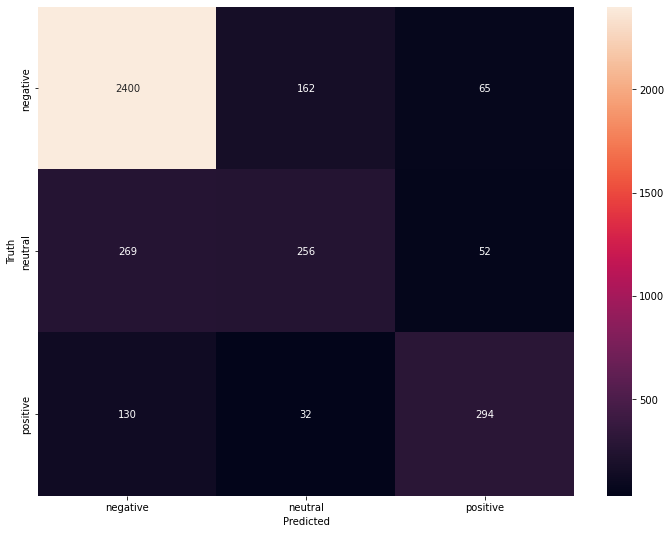

In [58]:
# create confusion matrix for TF-IDF Vectorizer
cm_tfidf=confusion_matrix(y_test , tf_idf_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_tfidf,annot=True,fmt='d',xticklabels=targets , yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

- The model is classifying 2,400 out of 2,627 negative tweets correctly (91%), 256 out of 577 neutral tweets correctly (44%), and 294 out of 456 positive tweets correctly (64%)

In [59]:
all_features = tfidf_vec.get_feature_names()                                    # instantiate the features from the vectorizer
top_features=''                                                                 # addition of top 40 features into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '

top_features 

'thank, delay, great, love, hours, hold, cancel, awesome, get, bag, best, fly, amaze, fleek, hour, please, service, time, wait, fleet, follow, would, make, call, plane, good, need, customer, help, flight, worst, dm, go, know, say, airline, lose, never, much, still, '

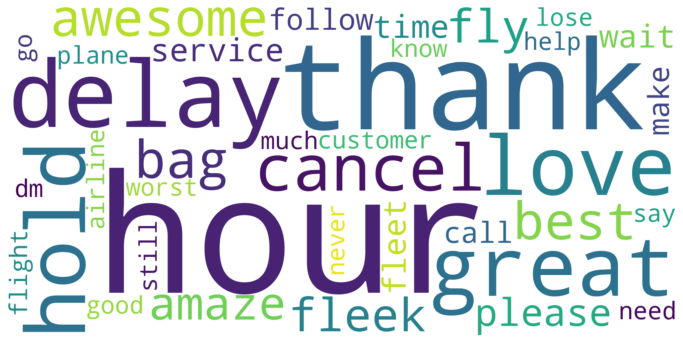

In [60]:
from wordcloud import WordCloud
# create word cloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# show word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [61]:
# saving variables for model
y_train_idf = y_train
y_test_idf = y_test

## Recurring Neural Network

In [62]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder

In [63]:
text_corpus = df_model.text
labels_corpus = df_model.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

In [64]:
# set hyperparameters
num_words=4000
maxlen=1000

In [65]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=num_words, char_level=False)

tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

len(sequences_train)

10980

In [66]:
# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)
print(type(X_train))

Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
<class 'numpy.ndarray'>


In [67]:
# encode target variable
label_encoder = LabelEncoder() 
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.fit_transform(y_test)

### Defining the model

In [68]:
from keras import backend
import tensorflow as tf
backend.clear_session()

# set the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [69]:
def create_model(maxlen,num_words,num_categories):
    
    model = Sequential()
    
    model.add(Embedding(num_words,output_dim=100,input_length=maxlen,trainable=True))
    
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(100)))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(128,activation='relu'))
    
    model.add(BatchNormalization())

    model.add(Dense(64,activation='relu'))
    
    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))
    
    model.add(Dense(num_categories, activation='softmax'))
              
    model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    model.summary()
    return model

In [70]:
model=create_model(maxlen,num_words,df_model.airline_sentiment.nunique())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         400000    
                                                                 
 batch_normalization (BatchN  (None, 1000, 100)        400       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [71]:
history = model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

Epoch 1/5
258/258 [==============================] - 34s 99ms/step - loss: 0.7794 - accuracy: 0.6748 - val_loss: 0.9795 - val_accuracy: 0.4015
Epoch 2/5
258/258 [==============================] - 25s 96ms/step - loss: 0.5232 - accuracy: 0.7965 - val_loss: 0.6307 - val_accuracy: 0.7180
Epoch 3/5
258/258 [==============================] - 25s 96ms/step - loss: 0.3894 - accuracy: 0.8553 - val_loss: 0.6036 - val_accuracy: 0.7723
Epoch 4/5
258/258 [==============================] - 25s 97ms/step - loss: 0.3001 - accuracy: 0.8879 - val_loss: 0.7170 - val_accuracy: 0.7548
Epoch 5/5
258/258 [==============================] - 25s 96ms/step - loss: 0.2356 - accuracy: 0.9128 - val_loss: 0.8537 - val_accuracy: 0.7534


### Model evaluation on training data

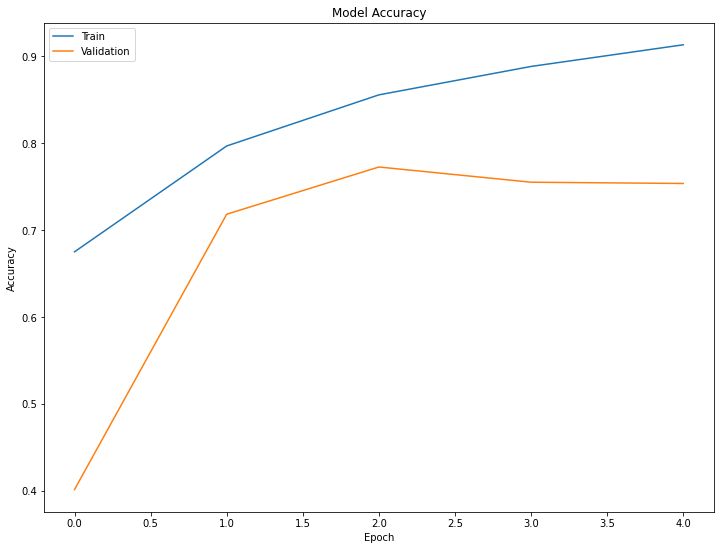

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model evaluation on test data

In [73]:
accuracy = model.evaluate(X_test, y_test_label, verbose=2)

115/115 - 4s - loss: 0.8261 - accuracy: 0.7560 - 4s/epoch - 32ms/step


In [74]:
#creating a dictionary to map model predictions to each sentiment
class_dict = {0:'negative',
 1:'neutral',
 2:'positive'}

In [75]:
#making predictions on the test data
y_pred_test = model.predict(X_test)

#converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

In [76]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes})

#replacing predictions with sentiments
label_df = df.replace({"Labels":class_dict})

#converting dataframe to array
y_pred_test_classes = label_df.to_numpy()

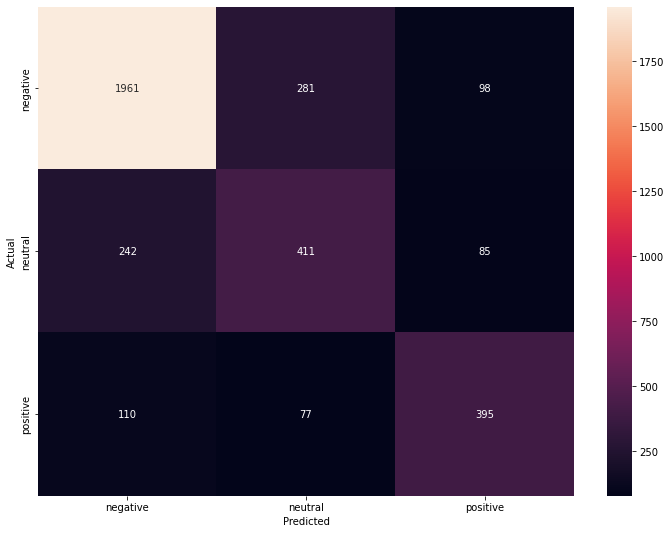

In [77]:
#plotting the heatmap using confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(12,9))
sns.heatmap(cm_rnn, annot=True,  fmt='.0f', xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- The model is classifying 1,961 out of 2,340 negative tweets correctly (84%), 411 out of 738 neutral tweets correctly (56%), and 395 out of 582 positive tweets correctly (68%)

## Conclusions

In [78]:
# provide a classification report on the Count Vectorizer model
print("Random Forest model trained with Count Vectorizer data")
print(" ")
print(classification_report(y_test_count , count_predicted, target_names = targets))
print(" ")

# provide a classification report on the TF-IDF Vectorizer model
print("Random Forest model trained with TF-IDF Vectorizer data")
print(" ")
print(classification_report(y_test_idf , tf_idf_predicted, target_names = targets))
print(" ")

# provide the classification report on the RNN model
print("Recurring Neural Network (RNN) model")
print(" ")
print(classification_report(y_test, y_pred_test_classes))

Random Forest model trained with Count Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      2627
     neutral       0.49      0.49      0.49       577
    positive       0.62      0.64      0.63       456

    accuracy                           0.78      3660
   macro avg       0.66      0.67      0.66      3660
weighted avg       0.78      0.78      0.78      3660

 
Random Forest model trained with TF-IDF Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      2627
     neutral       0.57      0.44      0.50       577
    positive       0.72      0.64      0.68       456

    accuracy                           0.81      3660
   macro avg       0.71      0.67      0.69      3660
weighted avg       0.79      0.81      0.80      3660

 
Recurring Neural Network (RNN) model
 
              precision    recall  f1-score   support

    negative       0.85  

- We created three classification models to predict the sentiments of tweets pertaining to one of six airlines
- The Random Forest classification model trained on data transfored from text into numbers through a TF-IDF vectorizer appears to perform the best, both in terms of overall accuracy and F1-scores across all three classes
- Given our analysis, each airline should understand which parts of the customer experience are most likely to drive positive and negative outcomes
- Additionally, given these models, each airline should be able to react to tweets with negative sentiment far quicker than through tradtional survey methods, potentially preventing or mitigating these daily occurences from materially harming their overall businesses